For the Maven Healthcare Challenge, you'll be working as a Data Analyst for the American Hospital Association (AHA), a national organization that represents hospitals and their patients, and acts as a source of information on health care issues and trends.

As part of your role, you've been asked to analyze the Hospital Consumer Assessment of Healthcare Providers and Systems (HCAHPS) survey results for the last 9 years. The intent of the HCAHPS initiative is to provide a standardized survey instrument for measuring patients’ perspectives on hospital care, and one of its 3 main goals is to "create incentives for hospitals to improve their quality of care".

Your task is to evaluate whether the HCAHPS survey has been successful in accomplishing this goal by answering questions like these:

Have hospitals' HCAHPS scores improved over the past 9 years?
Are there any specific areas where hospitals have made more progress than others?
Are there any major areas of opportunity remaining?
What recommendations can you make to hospitals to help them further improve the patient experience?


HCAHPS Patient Survey
National & state-level scores from 2013 to 2022 for the Hospital Consumer Assessment of Healthcare Providers and Systems (HCAHPS) survey, a national, standardized survey of hospital patients about their experiences during a recent inpatient hospital stay.

https://mavenanalytics.io/challenges/maven-healthcare-challenge/26


https://www.qualtrics.com/experience-management/customer/net-promoter-score/

# Maven Healthcare Challenge

This is project is my submission for the [Maven Healthcare Challenge](https://mavenanalytics.io/challenges/maven-healthcare-challenge/26). My goal is to analyze the Hospital Consumer Assessment of Healthcare Providers and Systems (HCAHPS) survey data and determine if it was able to 
improve quality of care and service to patients. 

The HCAHPS survey is required by the Centers for Medicare and Medicaid Services (CMS) for all hospitals in the United States and is used to measure patients' perspectives on hospital care. The results are made public to encourage hospitals to improve their quality of care and service to patients, and to empower patients to make informed decisions about where they receive care.


# Exploratory Data Analysis

I started by reviewing the provided data dictionary to have a better understanding of the data. The dataset contained multiple tables across 7 CSV files, 23 columns, and 47889 rows. 

To determine if hospital HCAHPS scores improved over time, I 

In [35]:
# Import packages
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import os
import geopandas as gpd
import contextily as cx
import plotly.express as px

In [2]:
# Read CSV files into dictionary
directory_path = 'data_tables/'
file_paths = [os.path.join(directory_path, file) for file in os.listdir(directory_path) if file.endswith('.csv')]
dataframes = {os.path.basename(file).replace('.csv', ''): pd.read_csv(file) for file in file_paths}


In [16]:
national_results = dataframes['national_results']
print(national_results.info())
print(national_results.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90 entries, 0 to 89
Data columns (total 5 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   Release Period         90 non-null     datetime64[ns]
 1   Measure ID             90 non-null     object        
 2   Bottom-box Percentage  90 non-null     int64         
 3   Middle-box Percentage  90 non-null     int64         
 4   Top-box Percentage     90 non-null     int64         
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 3.6+ KB
None
  Release Period   Measure ID  Bottom-box Percentage  Middle-box Percentage  \
0     2015-01-01  H_CLEAN_HSP                      8                     18   
1     2015-01-01     H_COMP_1                      4                     17   
2     2015-01-01     H_COMP_2                      4                     14   
3     2015-01-01     H_COMP_3                      9                     23   
4     2015-01-01

In [5]:
#Convert release period to datetime
national_results['Release Period'] = pd.to_datetime(national_results['Release Period'].str.lstrip('07_'))
national_results.head()

,Release Period,Measure ID,Bottom-box Percentage,Middle-box Percentage,Top-box Percentage
0,2015-01-01,H_CLEAN_HSP,8,18,74
1,2015-01-01,H_COMP_1,4,17,79
2,2015-01-01,H_COMP_2,4,14,82
3,2015-01-01,H_COMP_3,9,23,68
4,2015-01-01,H_COMP_5,18,17,65


In [7]:
national_results_rating = national_results[national_results['Measure ID'] == 'H_HSP_RATING']
national_results_rec = national_results[national_results['Measure ID'] == 'H_RECMND']

In [11]:

national_results_avg = national_results.groupby('Release Period')['Top-box Percentage'].agg(['mean', 'median', 'std']).reset_index()
national_results_avg

,Release Period,mean,median,std
0,2015-01-01,71.0,71.0,10.033278
1,2016-01-01,71.3,71.5,10.296170
2,2017-01-01,71.7,72.5,10.176771
3,2018-01-01,72.0,72.5,10.000000
4,2019-01-01,72.0,72.5,9.988883
5,2020-01-01,72.3,72.5,9.922477
6,2021-01-01,72.3,72.5,9.922477
7,2022-01-01,70.7,71.5,9.978310
8,2023-01-01,69.4,69.5,10.276186


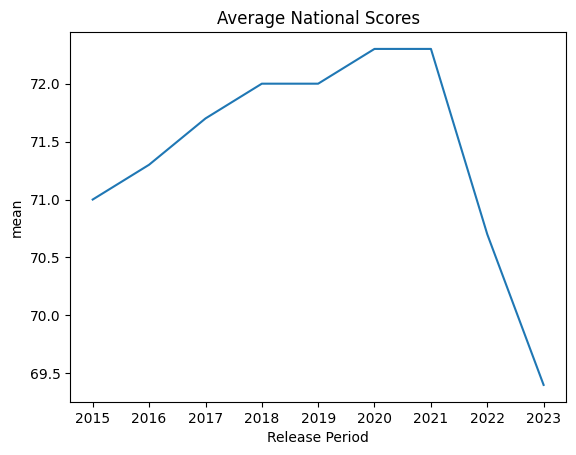

In [15]:
# Plot average national scores over time
sns.lineplot(data=national_results_avg, x='Release Period', y='mean')
plt.title('Average National Scores')


In [19]:
state_results = dataframes['state_results']
state_results['Release Period'] = pd.to_datetime(state_results['Release Period'].str.lstrip('07_'))

state_results.head()

,Release Period,State,Measure ID,Bottom-box Percentage,Middle-box Percentage,Top-box Percentage
0,2015-01-01,AK,H_CLEAN_HSP,8,22,70
1,2015-01-01,AK,H_COMP_1,9,17,74
2,2015-01-01,AK,H_COMP_2,10,15,75
3,2015-01-01,AK,H_COMP_3,11,21,68
4,2015-01-01,AK,H_COMP_5,19,17,64


In [28]:
state = dataframes['states']
state.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51 entries, 0 to 50
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   State       51 non-null     object
 1   State Name  51 non-null     object
 2   Region      51 non-null     object
dtypes: object(3)
memory usage: 1.3+ KB


In [29]:
statedf = state_results.merge(state, how='left', on='State')
statedf.head()

,Release Period,State,Measure ID,Bottom-box Percentage,Middle-box Percentage,Top-box Percentage,State Name,Region
0,2015-01-01,AK,H_CLEAN_HSP,8,22,70,Alaska,Pacific
1,2015-01-01,AK,H_COMP_1,9,17,74,Alaska,Pacific
2,2015-01-01,AK,H_COMP_2,10,15,75,Alaska,Pacific
3,2015-01-01,AK,H_COMP_3,11,21,68,Alaska,Pacific
4,2015-01-01,AK,H_COMP_5,19,17,64,Alaska,Pacific


In [30]:
state_results.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4580 entries, 0 to 4579
Data columns (total 6 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   Release Period         4580 non-null   datetime64[ns]
 1   State                  4580 non-null   object        
 2   Measure ID             4580 non-null   object        
 3   Bottom-box Percentage  4580 non-null   int64         
 4   Middle-box Percentage  4580 non-null   int64         
 5   Top-box Percentage     4580 non-null   int64         
dtypes: datetime64[ns](1), int64(3), object(2)
memory usage: 214.8+ KB


In [31]:
statedf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4580 entries, 0 to 4579
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   Release Period         4580 non-null   datetime64[ns]
 1   State                  4580 non-null   object        
 2   Measure ID             4580 non-null   object        
 3   Bottom-box Percentage  4580 non-null   int64         
 4   Middle-box Percentage  4580 non-null   int64         
 5   Top-box Percentage     4580 non-null   int64         
 6   State Name             4580 non-null   object        
 7   Region                 4580 non-null   object        
dtypes: datetime64[ns](1), int64(3), object(4)
memory usage: 286.4+ KB


In [20]:
state_results['Release Period'].value_counts()

Release Period
2015-01-01    510
2017-01-01    510
2018-01-01    510
2019-01-01    510
2020-01-01    510
2021-01-01    510
2022-01-01    510
2023-01-01    510
2016-01-01    500
Name: count, dtype: int64

In [23]:
state_results.isna().sum()

Release Period           0
State                    0
Measure ID               0
Bottom-box Percentage    0
Middle-box Percentage    0
Top-box Percentage       0
dtype: int64

In [33]:
gdf = gpd.GeoDataFrame(statedf)
gdf

,Release Period,State,Measure ID,Bottom-box Percentage,Middle-box Percentage,Top-box Percentage,State Name,Region
0,2015-01-01,AK,H_CLEAN_HSP,8,22,70,Alaska,Pacific
1,2015-01-01,AK,H_COMP_1,9,17,74,Alaska,Pacific
2,2015-01-01,AK,H_COMP_2,10,15,75,Alaska,Pacific
3,2015-01-01,AK,H_COMP_3,11,21,68,Alaska,Pacific
4,2015-01-01,AK,H_COMP_5,19,17,64,Alaska,Pacific
...,...,...,...,...,...,...,...,...
4575,2023-01-01,WY,H_COMP_6,14,0,86,Wyoming,Mountain
4576,2023-01-01,WY,H_COMP_7,5,41,54,Wyoming,Mountain
4577,2023-01-01,WY,H_HSP_RATING,7,22,71,Wyoming,Mountain
4578,2023-01-01,WY,H_QUIET_HSP,6,28,66,Wyoming,Mountain


In [37]:
fig = px.choropleth(statedf, locations='State', locationmode='USA-states', scope='usa')
fig.show()